# Diffusion 1D

## Question 2(a)

Let's break down the [problem statement](0.Kinetics_Module_Problems.ipynb) for question **2(a)**:

### Declare simulation parameters

**note:**
- Distances are in micrometers
- Diffusion coefficient `DP` is in micrometers squared per second
- Times are in seconds

> A $7~\mathrm{\mu m}$ thick B-doped (p-type) Si wafer is annealed at $950~\mathrm{{}^\circ C}$ while in equilibrium with a gas containing P vapor (donor).

In [1]:
wafer_thickness = 7.0

> The concentration of B in the wafer is $2\times 10^{17} / \mathrm{cm^3} = 2\times 10^5/\mathrm{\mu m^3}$.

In [2]:
CB = 2e5 # Bulk concentration of boron

> P diffusivity in this system at this condition is $D_P\approx 10^{-14}~\mathrm{cm^2/s} = 10^{-6}~\mathrm{\mu m^2/s}$.

In [3]:
DP = 1.0e-6 # Diffusion coefficient

> Assume that the concentration of P at the surface in this case is $10^{21}/\mathrm{cm^3} = 10^9/\mathrm{\mu m^3}$.

In [4]:
CPsurf = 1.0e9 # Surface concentration of phosphorus

> To fabricate a device with a junction at approximately $1~\mathrm{\mu m}$ from the surface, one would like to match the P and B concentrations at a depth of $1~\mathrm{\mu m}$.

In [5]:
junction_depth = 1.0 # Distance at which we will output concentration

> Try time steps of 2, 20 and 200 and 2000 s.  For a time of 10 hours and a distance of 1 μm, what value of time step gives agreement with the analytical solution to within one percent?

In [6]:
dt = 20.0 # Time step
final_time = 36000 # total amount of time simulated

### Import FiPy

In [7]:
import fipy as fp

### Define simulation domain

Subdivide the 1D domain into 700 "cells" of $10~\mathrm{nm}$ width (you can experiment with the effect on the error by changing this value).

In [8]:
nx = 700 # number of grid elements

mesh = fp.Grid1D(nx=nx, Lx=wafer_thickness)

### Define solution variable(s)

Declare memory storage for the P concentration across the cells of the mesh defined above. Initialize the concentration to zero and inform FiPy that the concentration will evolve in time.

In [9]:
CP = fp.CellVariable(mesh=mesh, name="$C_P$", value=0.0, hasOld=True)

### Define analytical solution

> The following analytical formula determines the concentration of P at a distance $x = 1~\mathrm{\mu m}$ from the surface to be equal to the concentration of B. 
> 
> \begin{align}
  C_P(x, t) = C_{P,\text{surface}} \left(1 - \mathrm{erf} \frac{x}{2\sqrt{D_P t}}\right)
  \end{align}
> 
> **Note:** The `erf` function and its inverse can be evaluated using SciPy (you can also consider using the complementary error function, `erfc`, which is one minus the error function).

In [10]:
from scipy.special import erf

def analytical(x, t):
    return CPsurf * (1 - erf(x / (2 * fp.numerix.sqrt(DP * t))))

In [11]:
CPanalytical = fp.CellVariable(mesh=mesh, name="$C_{P,\text{analytical}}$")
CPanalytical.setValue(analytical(x=mesh.x, t=final_time))

We can also write the above equation as

\begin{align}
  C_P(x, t) = C_{P,\text{surface}} \mathrm{erfc} \frac{x}{2\sqrt{D_P t}}
\end{align}

In [12]:
from scipy.special import erfc

def analyticalc(x, t):
    return CPsurf * erfc(x / (2 * fp.numerix.sqrt(DP * t)))

What are the advantages of one form over the other? (**Hint:** Try plotting each over a range of $t$ values.)

**note:** It's also possible to import the `sqrt()` function directly from either the `math` or `numpy` package. `fp.numerix` is a superset of `numpy` that customizes some math operations; it's generally best to just use `fp.numerix` everywhere when working with FiPy. 

For comparison:
- [`math`](https://docs.python.org/3/library/math.html) performs calculations with individual numbers.
- [`numpy`](https://numpy.org) performs calculations with arrays of numbers.
- [`fipy.numerix`](https://www.ctcms.nist.gov/fipy/fipy/generated/fipy.tools.html#module-fipy.tools.numerix) performs calculations with fields of numbers that are located on a FiPy `Mesh`.

### Define equation(s)

We want to solve [Fick's 2nd Law of diffusion](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion#Fick's_second_law), the 1D partial differential equation
$$\frac{\partial C_P}{\partial t} = \frac{\partial}{\partial x}\left(D_P \frac{\partial C_P}{\partial x}\right)$$

In [13]:
eq = fp.TransientTerm(var=CP) == fp.DiffusionTerm(coeff=DP, var=CP)

### Specify boundary condition(s)

FiPy's boundary conditions are no-flux by default. We define a [Dirichlet condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) to fix the concentration at the left-hand side of the domain, which we take to be the wafer surface.

In [14]:
CP.constrain(CPsurf, where=mesh.facesLeft)

### Create viewer

`fp.Viewer()` is a general purpose routine that does its best to create a visualization using a variety of different plotting packages. Explicitly using the [`matplotlib`](https://matplotlib.org) package enables customization for more informative plots.

In [15]:
from matplotlib import pyplot as plt

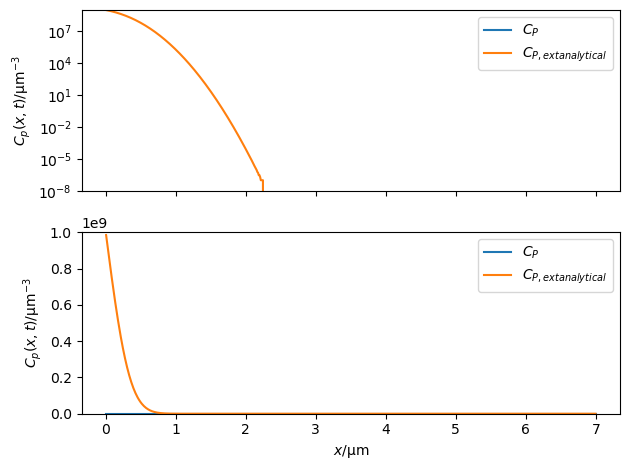

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)

logviewer = fp.MatplotlibViewer(vars=(CP, CPanalytical),
                                datamin=1e-8, datamax=CPsurf,
                                axes=axs[0], log=True, legend="upper right")
axs[0].set_ylabel(r"$C_p(x,t) / \mathrm{\mu m}^{-3}$")

linviewer = fp.MatplotlibViewer(vars=(CP, CPanalytical),
                                datamin=0., datamax=CPsurf,
                                axes=axs[1], log=False, legend="upper right")
axs[1].set_ylabel(r"$C_p(x,t) / \mathrm{\mu m}^{-3}$")
axs[1].set_xlabel(r"$x / \mathrm{\mu m}$")

plt.tight_layout()

### Solve problem

In [17]:
# FiPy 3.4.3 has a memory leak when using PETSc
from petsc4py import PETSc

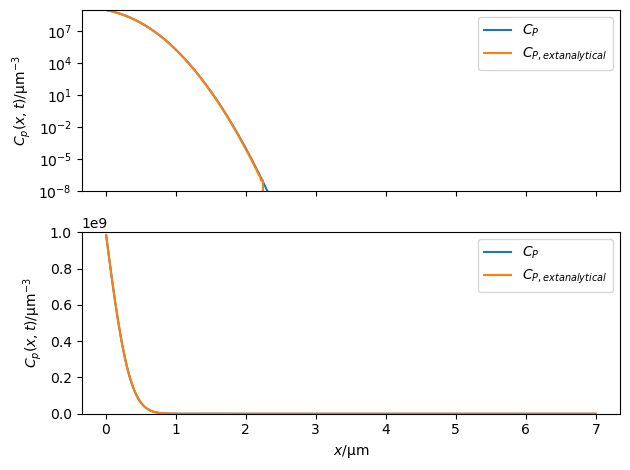


        DP = 1e-06 µm**2/s
        dt = 2.0 s
        time = 36000.0 s
        concentration at output distance = 195360.65259653522 / µm**3
        analytical concentration at output distance = 193941.62910371885 / µm**3
        error = 0.7316755558743319 %
        


In [18]:
CP.value = 0. # reset solution
dt = 2.0
t = 0
while t <= final_time:
    t=t+dt
    CP.updateOld()
    eq.solve(dt=dt)
    if t % 1800 == 0:
        cm = CP([junction_depth],order=1) # interpolate the value at depth of interest
        ca = analyticalc(x=junction_depth, t=t)
        ## for 2.10, uncomment the following lines and make the viewer.plot() line a comment
        logviewer.plot()
        linviewer.plot()
        # viewer.plot(filename="%g-plot.png" % t)
        # TSVViewer(vars=C).plot(filename="%g-data.txt" %t)
        print(f"""
        DP = {DP} µm**2/s
        dt = {dt} s
        time = {t} s
        concentration at output distance = {cm} / µm**3
        analytical concentration at output distance = {ca} / µm**3
        error = {100 * (cm - ca) / ca} %
        """)
        
        # FiPy 3.4.3 has a memory leak when using PETSc
        PETSc.garbage_cleanup()        

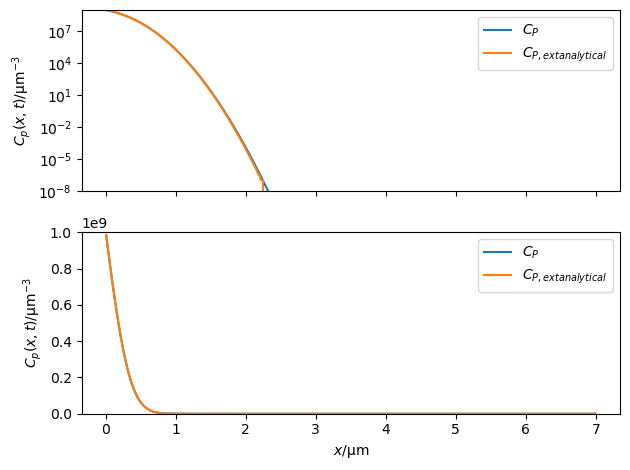


        DP = 1e-06 µm**2/s
        dt = 20.0 s
        time = 36000.0 s
        concentration at output distance = 197313.7293806258 / µm**3
        analytical concentration at output distance = 193941.62910371885 / µm**3
        error = 1.7387191664269077 %
        


In [19]:
CP.value = 0. # reset solution
dt = 20.0
t = 0
while t <= final_time:
    t=t+dt
    CP.updateOld()
    eq.solve(dt=dt)
    if t % 1800 == 0:
        cm = CP([junction_depth],order=1) # interpolate the value at depth of interest
        ca = analyticalc(x=junction_depth, t=t)
        ## for 2.10, uncomment the following lines and make the viewer.plot() line a comment
        logviewer.plot()
        linviewer.plot()
        # viewer.plot(filename="%g-plot.png" % t)
        # TSVViewer(vars=C).plot(filename="%g-data.txt" %t)
        print(f"""
        DP = {DP} µm**2/s
        dt = {dt} s
        time = {t} s
        concentration at output distance = {cm} / µm**3
        analytical concentration at output distance = {ca} / µm**3
        error = {100 * (cm - ca) / ca} %
        """)
        
        # FiPy 3.4.3 has a memory leak
        PETSc.garbage_cleanup()        

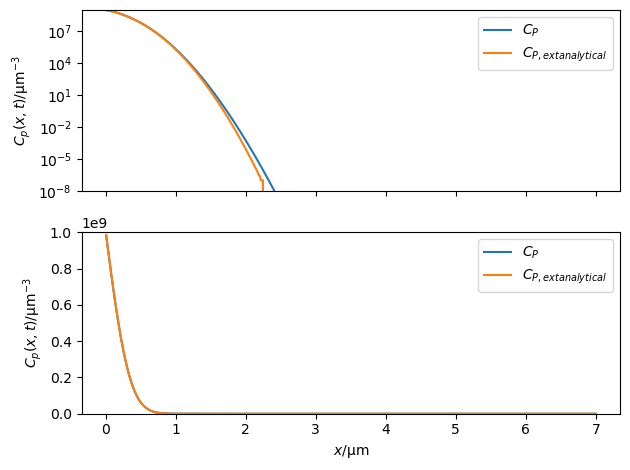


        DP = 1e-06 µm**2/s
        dt = 200.0 s
        time = 36000.0 s
        concentration at output distance = 217054.61704209688 / µm**3
        analytical concentration at output distance = 193941.62910371885 / µm**3
        error = 11.917497055785452 %
        


In [20]:
CP.value = 0. # reset solution
dt = 200.0
t = 0
while t <= final_time:
    t=t+dt
    CP.updateOld()
    eq.solve(dt=dt)
    if t % 1800 == 0:
        cm = CP([junction_depth],order=1) # interpolate the value at depth of interest
        ca = analyticalc(x=junction_depth, t=t)
        ## for 2.10, uncomment the following lines and make the viewer.plot() line a comment
        logviewer.plot()
        linviewer.plot()
        # viewer.plot(filename="%g-plot.png" % t)
        # TSVViewer(vars=C).plot(filename="%g-data.txt" %t)
        print(f"""
        DP = {DP} µm**2/s
        dt = {dt} s
        time = {t} s
        concentration at output distance = {cm} / µm**3
        analytical concentration at output distance = {ca} / µm**3
        error = {100 * (cm - ca) / ca} %
        """)
        
        # FiPy 3.4.3 has a memory leak
        PETSc.garbage_cleanup()        

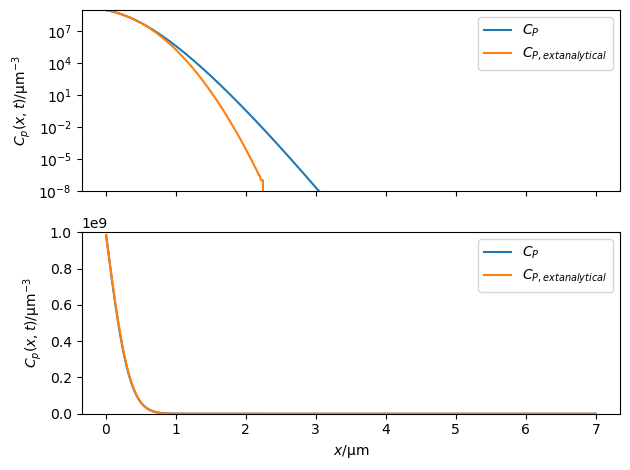


        DP = 1e-06 µm**2/s
        dt = 2000.0 s
        time = 36000.0 s
        concentration at output distance = 431868.52181624656 / µm**3
        analytical concentration at output distance = 193941.62910371885 / µm**3
        error = 122.67964016394117 %
        


In [21]:
CP.value = 0. # reset solution
dt = 2000.0
t = 0
while t <= final_time:
    t=t+dt
    CP.updateOld()
    eq.solve(dt=dt)
    if t % 1800 == 0:
        cm = CP([junction_depth],order=1) # interpolate the value at depth of interest
        ca = analyticalc(x=junction_depth, t=t)
        ## for 2.10, uncomment the following lines and make the viewer.plot() line a comment
        logviewer.plot()
        linviewer.plot()
        # viewer.plot(filename="%g-plot.png" % t)
        # TSVViewer(vars=C).plot(filename="%g-data.txt" %t)
        print(f"""
        DP = {DP} µm**2/s
        dt = {dt} s
        time = {t} s
        concentration at output distance = {cm} / µm**3
        analytical concentration at output distance = {ca} / µm**3
        error = {100 * (cm - ca) / ca} %
        """)
        
        # FiPy 3.4.3 has a memory leak
        PETSc.garbage_cleanup()        

## Question 2(b)

The error function solution given above assumes an infinitely thick domain.  Since your sample has finite thickness, this solution will not be accurate for your finite-sized sample beyond some time.  To appreciate the effect, modify the code so that your sample is $1.02~\mathrm{\mu m}$ thick.  Compute the concentration at a depth of $1.02~\mathrm{\mu m}$ after 10 hours (using the converged time step from part [(a)](#2(a)) and compare with the analytical solution.

In [22]:
wafer_thinness = 1.02 # thickness of wafer

### Define simulation domain

In [23]:
nx_thin = 102 # number of grid elements

mesh_thin = fp.Grid1D(nx=nx_thin, Lx=wafer_thinness)

### Define solution variable(s)

In [24]:
CP_thin = fp.CellVariable(mesh=mesh_thin, name="$C_P$", value=0.0, hasOld=True)

### Define analytical solution

In [25]:
CPanalytical_thin = fp.CellVariable(mesh=mesh_thin, name="$C_{P,\text{analytical}}$")
CPanalytical_thin.setValue(analytical(x=mesh_thin.x, t=final_time))

### Define equation(s)

In [26]:
eq_thin = fp.TransientTerm(var=CP_thin) == fp.DiffusionTerm(coeff=DP, var=CP_thin)

### Specify boundary condition(s)

In [27]:
CP_thin.constrain(CPsurf, where=mesh_thin.facesLeft)

### Create viewer

<Figure size 640x480 with 0 Axes>

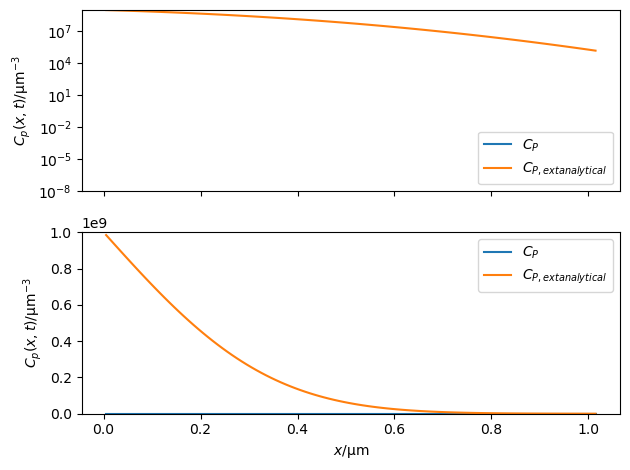

In [28]:
fig_thin, axs_thin = plt.subplots(2, 1, sharex=True)

logviewer_thin = fp.MatplotlibViewer(vars=(CP_thin, CPanalytical_thin),
                                datamin=1e-8, datamax=CPsurf,
                                axes=axs_thin[0], log=True, legend="lower right")
axs_thin[0].set_ylabel(r"$C_p(x,t) / \mathrm{\mu m}^{-3}$")

linviewer_thin = fp.MatplotlibViewer(vars=(CP_thin, CPanalytical_thin),
                                datamin=0., datamax=CPsurf,
                                axes=axs_thin[1], log=False, legend="upper right")
axs_thin[1].set_ylabel(r"$C_p(x,t) / \mathrm{\mu m}^{-3}$")
axs_thin[1].set_xlabel(r"$x / \mathrm{\mu m}$")

plt.tight_layout()

### Solve problem

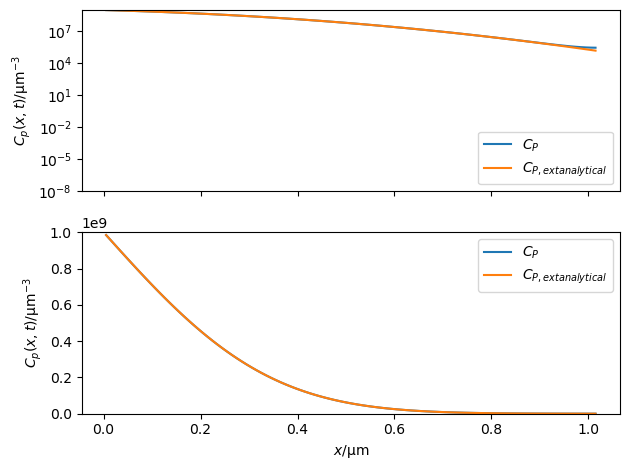


        DP = 1e-06 µm**2/s
        dt = 2.0 s
        time = 36000.0 s
        concentration at output distance = 302497.1403966929 / µm**3
        analytical concentration at output distance = 193941.62910371885 / µm**3
        error = 55.97329041457066 %
        


In [29]:
CP_thin.value = 0. # reset solution
dt = 2.0
t = 0
while t <= final_time:
    t=t+dt
    CP_thin.updateOld()
    eq_thin.solve(dt=dt)
    if t % 1800 == 0:
        cm = CP_thin([junction_depth],order=1) # interpolate the value at depth of interest
        ca = analyticalc(x=junction_depth, t=t)
        ## for 2.10, uncomment the following lines and make the viewer.plot() line a comment
        logviewer_thin.plot()
        linviewer_thin.plot()
        # viewer.plot(filename="%g-plot.png" % t)
        # TSVViewer(vars=C).plot(filename="%g-data.txt" %t)
        print(f"""
        DP = {DP} µm**2/s
        dt = {dt} s
        time = {t} s
        concentration at output distance = {cm} / µm**3
        analytical concentration at output distance = {ca} / µm**3
        error = {100 * (cm - ca) / ca} %
        """)
        
        # FiPy 3.4.3 has a memory leak when using PETSc
        PETSc.garbage_cleanup()        